In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import re
import datetime

%matplotlib inline


In [2]:
df = pd.read_csv('../Data/amazon_clean_0512.csv', index_col=0)
df.head(2)

,name,price_current,price_original,reviews_number,seller,score,brand,Series,Color,height_cm,...,Tipo de conexión inalámbrica,usb_2,usb_3,Tipo de unidad óptica,os,battery_wh,battery_cells,weight_kg,Número de modelo del producto,since
0,"Huawei MateBook D 15"" - AMD Ryzen, Windows 10-...",14999.0,NaN,156.0,Huawei,4.7,Huawei,Matebook D 15,Gris,0.17,...,Bluetooth,2.0,1.0,None,Windows 10 Home,42.0,2.0,2.3,6901443370764,2020-02-20
1,"Asus Laptop VivoBook 15.6"", Core i7, 8GB RAM,...",17999.0,19999.0,NaN,Asus,NaN,Asus,X512FA-BR1412T,NaN,NaN,...,NaN,2.0,2.0,Ninguno,Windows 10,1000.0,1.0,2.5,NaN,2020-03-10


## Droping unuseful column to this case

In [3]:
df = df.drop(columns=[
    'Tecnología de la memoria', 
    'Tipo de unidad óptica', 
    'Tipo de conexión inalámbrica', 
    'Número de modelo del producto',
    'usb_3',
    'usb_2',
    'Series',
    'Color',
    'Descripción del disco duro',
    'Tipo de RAM para gráficos',
    'memory_interface',
    'gpu_interface',
    'resolution_x',
    'resolution_y',
    'gpu_ram',
    'Descripción de la tarjeta gráfica',
    'Coprocesador de gráficos',
    'Tipo de procesador'
    ])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 512 entries, 0 to 511
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            512 non-null    object 
 1   price_current   220 non-null    float64
 2   price_original  41 non-null     float64
 3   reviews_number  469 non-null    float64
 4   seller          512 non-null    object 
 5   score           469 non-null    float64
 6   brand           512 non-null    object 
 7   height_cm       469 non-null    float64
 8   width_cm        468 non-null    float64
 9   screen_size_in  509 non-null    float64
 10  proc_brand      488 non-null    object 
 11  proc_speed_ghz  448 non-null    float64
 12  ram             506 non-null    float64
 13  ram_type        368 non-null    object 
 14  ram_max         342 non-null    float64
 15  memory          429 non-null    float64
 16  os              496 non-null    object 
 17  battery_wh      508 non-null    flo

## Converting dtypes

In [5]:
df = df.convert_dtypes()


In [6]:
df.brand = df.brand.str.lower()
df.brand = df.brand.astype('category')

In [7]:
df.seller = df.seller.str.lower()
df.seller = df.seller.astype('category')


In [8]:
df.proc_brand = df.proc_brand.astype('category')


In [9]:
df.os = df.os.astype('category')


In [10]:
df.ram_type = df.ram_type.astype('category')

In [11]:
df.since = pd.to_datetime(df.since)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 512 entries, 0 to 511
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   name            512 non-null    string        
 1   price_current   220 non-null    float64       
 2   price_original  41 non-null     float64       
 3   reviews_number  469 non-null    Int64         
 4   seller          512 non-null    category      
 5   score           469 non-null    float64       
 6   brand           512 non-null    category      
 7   height_cm       469 non-null    float64       
 8   width_cm        468 non-null    float64       
 9   screen_size_in  509 non-null    Int64         
 10  proc_brand      488 non-null    category      
 11  proc_speed_ghz  448 non-null    float64       
 12  ram             506 non-null    Int64         
 13  ram_type        368 non-null    category      
 14  ram_max         342 non-null    Int64         
 15  memory

In [13]:
df.describe()

,price_current,price_original,reviews_number,score,height_cm,width_cm,screen_size_in,proc_speed_ghz,ram,ram_max,memory,battery_wh,battery_cells,weight_kg
count,220.000000,41.000000,469.000000,469.000000,469.000000,468.000000,509.000000,448.000000,506.000000,342.000000,429.000000,5.080000e+02,491.000000,512.000000
mean,24738.809727,25876.765366,165.200426,3.952665,4.522495,24.488654,15.007859,9.980089,11.845850,31.301170,374.284382,1.976488e+04,3.179226,4.599219
std,19197.740655,16406.351173,440.464016,0.664112,9.792554,10.732078,1.602145,120.890180,28.809239,91.548874,394.249285,4.436748e+05,2.625708,36.170971
min,3783.700000,9239.000000,1.000000,1.000000,0.070000,0.080000,7.000000,0.800000,1.000000,0.000000,1.000000,1.000000e+00,1.000000,1.000000
25%,12499.000000,13999.000000,6.000000,3.600000,0.180000,22.575000,14.000000,1.750000,4.000000,8.000000,32.000000,3.175000e+01,2.000000,2.200000
50%,19894.500000,21499.010000,28.000000,4.000000,0.220000,25.450000,16.000000,2.300000,8.000000,16.000000,256.000000,4.200000e+01,3.000000,2.600000
75%,28810.000000,31188.000000,109.000000,4.300000,0.280000,30.500000,16.000000,2.825000,12.000000,32.000000,512.000000,5.100000e+01,4.000000,3.425000
max,152650.000000,71598.680000,4382.000000,5.000000,47.700000,57.400000,18.000000,2400.000000,512.000000,1024.000000,2048.000000,1.000000e+07,45.000000,821.000000


In [14]:
df.describe(include='category')

,seller,brand,proc_brand,ram_type,os
count,512,512,488,368,496
unique,32,32,16,11,26
top,asus,asus,Intel,DDR4,Windows 10
freq,108,108,388,211,252


## Working with NAs and duplicates

#### Features to simplify the management of NaNs

In [15]:
def most_common(column):
    return column.value_counts().first_valid_index()

In [16]:
def repl_na(column, default = True, value = -1):
    if default:
        if column.dtype == 'Int64' or column.dtype == 'float64':
            column.fillna(column.median(), inplace=True)

        elif column.dtype == 'category':
            column.fillna(most_common(column), inplace=True)
    else:
        column.fillna(value, inplace=True)

#### Filling some fields with customs values

In [17]:
repl_na(df.price_original, False, df.price_current)

#### The remaining columns with NaNs will be replaced by the most common value for categoricals and by the median for numericals

In [18]:
df.columns[df.isna().any()]

Index(['price_current', 'price_original', 'reviews_number', 'score',
       'height_cm', 'width_cm', 'screen_size_in', 'proc_brand',
       'proc_speed_ghz', 'ram', 'ram_type', 'ram_max', 'memory', 'os',
       'battery_wh', 'battery_cells'],
      dtype='object')

In [19]:
for column in df.columns[df.isna().any()]:
    repl_na(df[column])


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 512 entries, 0 to 511
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   name            512 non-null    string        
 1   price_current   512 non-null    float64       
 2   price_original  512 non-null    float64       
 3   reviews_number  512 non-null    Int64         
 4   seller          512 non-null    category      
 5   score           512 non-null    float64       
 6   brand           512 non-null    category      
 7   height_cm       512 non-null    float64       
 8   width_cm        512 non-null    float64       
 9   screen_size_in  512 non-null    Int64         
 10  proc_brand      512 non-null    category      
 11  proc_speed_ghz  512 non-null    float64       
 12  ram             512 non-null    Int64         
 13  ram_type        512 non-null    category      
 14  ram_max         512 non-null    Int64         
 15  memory

In [21]:
df.describe()

,price_current,price_original,reviews_number,score,height_cm,width_cm,screen_size_in,proc_speed_ghz,ram,ram_max,memory,battery_wh,battery_cells,weight_kg
count,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,5.120000e+02,512.000000,512.000000
mean,21976.039336,22518.018516,153.677734,3.956641,4.161152,24.571270,15.013672,9.020078,11.800781,26.220703,355.109375,1.961079e+04,3.171875,4.599219
std,12795.056097,13051.371111,423.242196,0.635692,9.447309,10.263177,1.599232,113.095182,28.642601,75.132942,363.442246,4.419383e+05,2.571435,36.170971
min,3783.700000,3783.700000,1.000000,1.000000,0.070000,0.080000,7.000000,0.800000,1.000000,0.000000,1.000000,1.000000e+00,1.000000,1.000000
25%,19894.500000,20224.500000,7.000000,3.700000,0.180000,22.600000,14.000000,1.800000,4.000000,8.000000,64.000000,3.200000e+01,2.000000,2.200000
50%,19894.500000,20224.500000,28.000000,4.000000,0.220000,25.450000,16.000000,2.300000,8.000000,16.000000,256.000000,4.200000e+01,3.000000,2.600000
75%,19894.500000,20224.500000,92.000000,4.300000,0.260000,29.200000,16.000000,2.700000,12.000000,16.000000,512.000000,5.100000e+01,4.000000,3.425000
max,152650.000000,152650.000000,4382.000000,5.000000,47.700000,57.400000,18.000000,2400.000000,512.000000,1024.000000,2048.000000,1.000000e+07,45.000000,821.000000


In [22]:
df.describe(include='category')

,seller,brand,proc_brand,ram_type,os
count,512,512,512,512,512
unique,32,32,16,11,26
top,asus,asus,Intel,DDR4,Windows 10
freq,108,108,412,355,268


## Detecting and managing outliers

#### Configuration for plotting

In [23]:
def plot_color(color_fractions, patches_to_paint, color_to_paint=plt.cm.Blues):
    color_normalized = matplotlib.colors.Normalize(color_fractions.min(), color_fractions.max())

    for fraction, patch in zip(color_fractions, patches_to_paint):
        color = color_to_paint(color_normalized(fraction))
        patch.set_facecolor(color)

In [24]:
def boxplot_config(ax, x, labels=None, title='', x_label='', y_label=''):
    # Personalization of siymbols and lines
    boxprops = dict( linestyle='--', linewidth=1, color='black' )
    flierprops = dict( marker='o', markerfacecolor='skyblue', markersize=6, label='outlier' )
    medianprops = dict( linestyle='-.', linewidth=2.5, color='green', label='median' )
    meanpointprops = dict( marker='D', markeredgecolor='black', markerfacecolor='skyblue', label='mean' )

    bbplot_patches = ax.boxplot(x,
                    patch_artist=True,  # enable fill with color
                    labels=labels,
                    showmeans = True,
                    boxprops=boxprops,
                    flierprops=flierprops,
                    medianprops=medianprops,
                    meanprops=meanpointprops
                    )

    # Assigning color for each box
    box_number = len( bbplot_patches['boxes'] )
    color_fractions = np.array( list( range(box_number) ) ) / box_number
    plot_color(color_fractions, bbplot_patches['boxes'], plt.cm.tab20)
    
    # Adding labels
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.legend()


In [25]:
def histogram_config(ax, x, title='', x_label='', y_label=''):
    frequencies, _ , bar_patches = ax.hist(x, edgecolor='k', linewidth=1)
    
    color_fractions = frequencies / frequencies.max()
    plot_color(color_fractions, bar_patches)

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.tick_params(axis='x', labelrotation=90)
    ax.tick_params(axis='y', labelrotation=45)


In [26]:
def _print_plots(dataframe, dtype, plot_cols, plot_func):
    columns_names = dataframe.select_dtypes(include=dtype).columns

    plots_quantity = len( columns_names )

    plot_rows = int( np.ceil( plots_quantity / plot_cols ) )
    plot_size_y = plot_rows * 5
    plot_size_x = plot_cols * 10

    fig, ax = plt.subplots( plot_rows, plot_cols, figsize=(plot_size_x, plot_size_y) )

    for nrow in range(plot_rows):
        for ncol in range(plot_cols):
            if plots_quantity >= 1:
                plots_quantity -= 1
                plot_func( ax[nrow][ncol], dataframe[ columns_names[plots_quantity] ], title=columns_names[plots_quantity] )
            else:
                break

In [27]:
def dynamic_plot(dataframe, dtype = 'number', plot_cols = 2):
    isint = 'int' in ''.join(dtype).lower()
    isfloat = 'float' in ''.join(dtype).lower()
    isnumber_type = dtype == 'number'  or isint or isfloat

    if dtype == 'category':
        _print_plots(dataframe, dtype, plot_cols, histogram_config)

    elif isnumber_type:
        _print_plots(dataframe, dtype, plot_cols, boxplot_config)

### Plotting

In [28]:
df.select_dtypes(include = 'number').columns

Index(['price_current', 'price_original', 'reviews_number', 'score',
       'height_cm', 'width_cm', 'screen_size_in', 'proc_speed_ghz', 'ram',
       'ram_max', 'memory', 'battery_wh', 'battery_cells', 'weight_kg'],
      dtype='object')

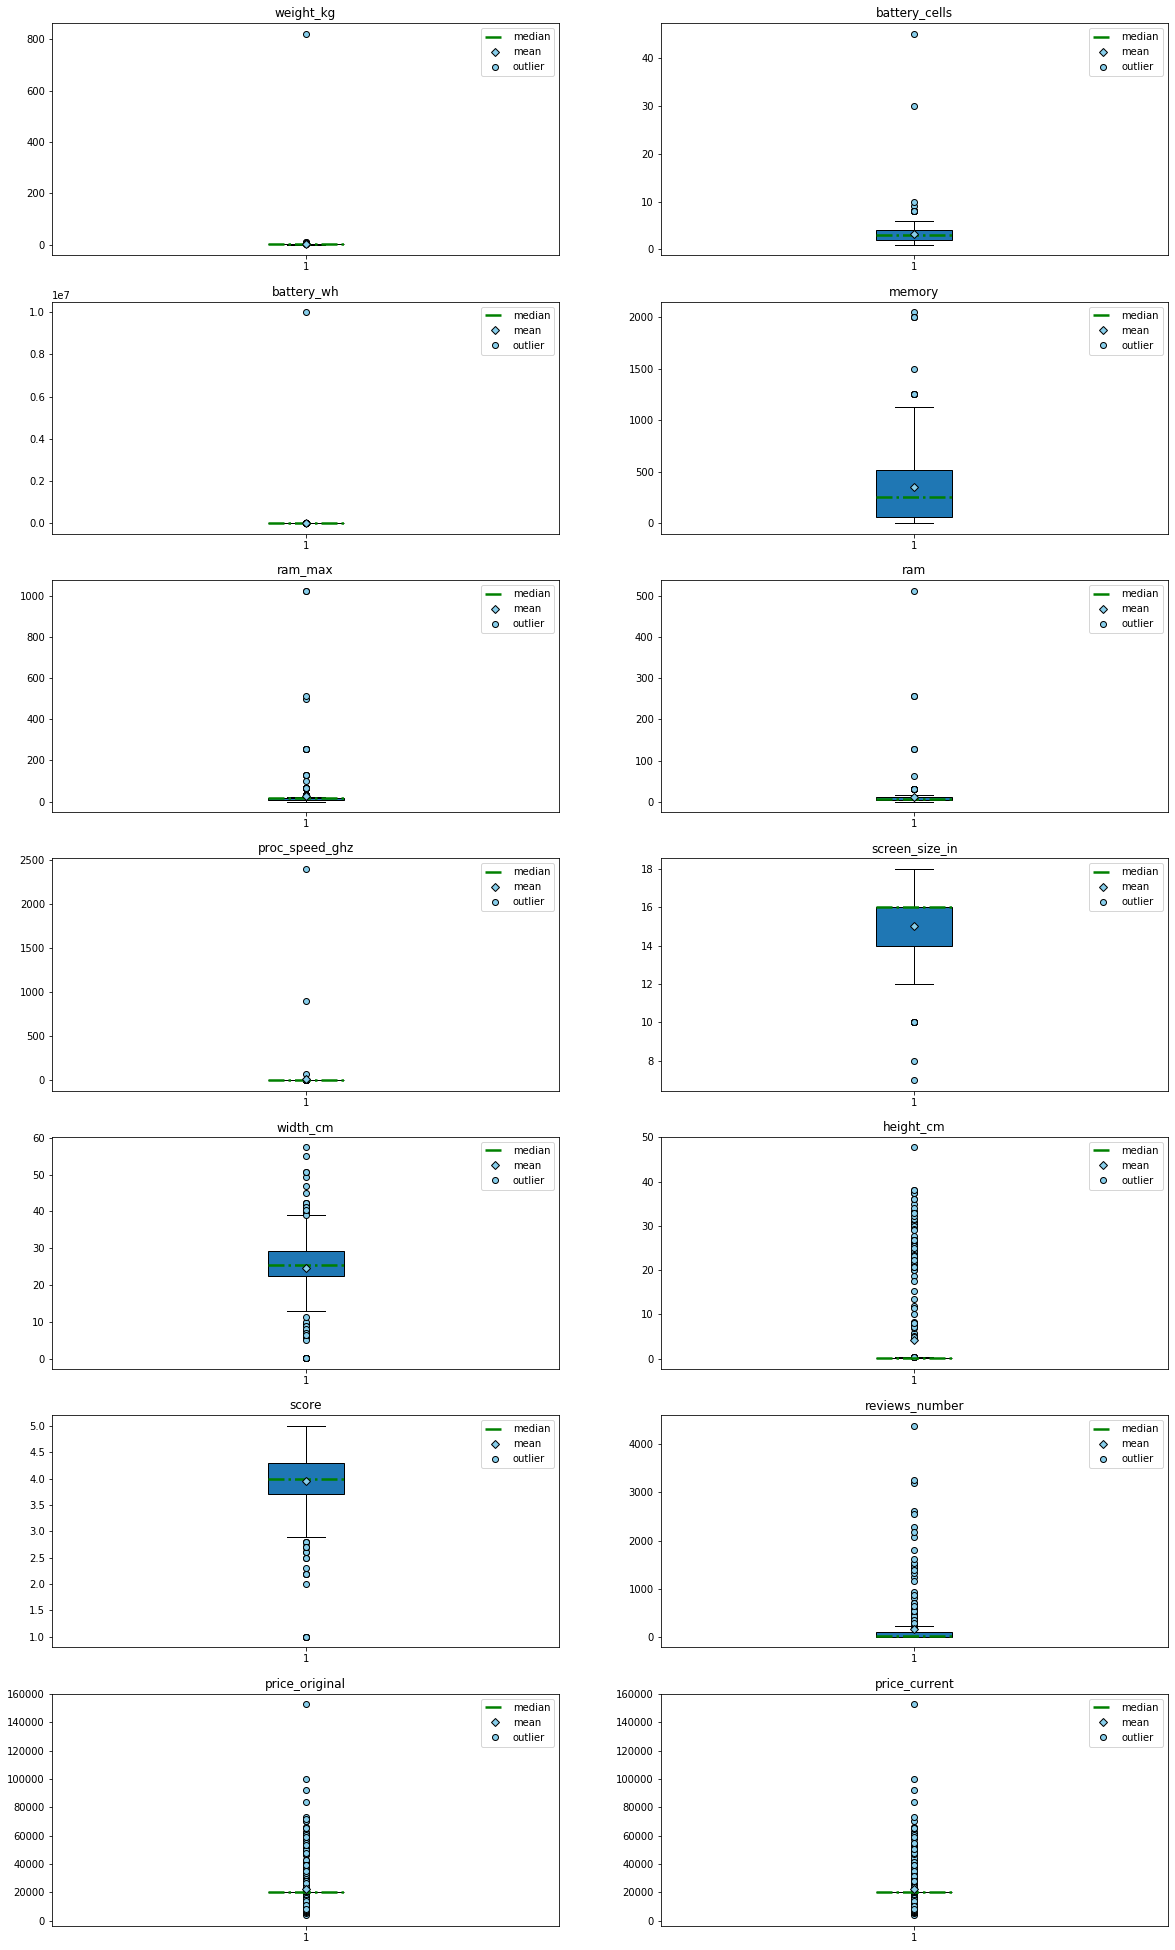

In [29]:
dynamic_plot(df)

### Hunting Outliers & duplicates

In [30]:
df.drop(df[df.price_current > 40000].index,axis=0, inplace=True)
df = df.reset_index(drop=True)

In [31]:
df.height_cm[df.height_cm > 3] = df.height_cm.median()

In [32]:
df.width_cm[(df.width_cm > 45) | (df.width_cm < 18)] = df.width_cm.median()

In [33]:
df.proc_speed_ghz[df.proc_speed_ghz > 500] = df.proc_speed_ghz[df.proc_speed_ghz > 500] / 1000
df.proc_speed_ghz[df.proc_speed_ghz == 64] = df.proc_speed_ghz.median()

In [34]:
df.ram[df.ram > 128] = df.ram.median()

In [35]:
df.ram_max[df.ram_max > 128] = df.ram_max.median()

In [36]:
df.battery_wh[df.battery_wh > 1e+02] = df.battery_wh.median()

In [37]:
df.battery_cells[df.battery_cells > 6] = df.battery_cells.median()

In [38]:
df.weight_kg[df.weight_kg > 7] = df.weight_kg.median()

In [39]:
df.select_dtypes(include='category').columns

Index(['seller', 'brand', 'proc_brand', 'ram_type', 'os'], dtype='object')

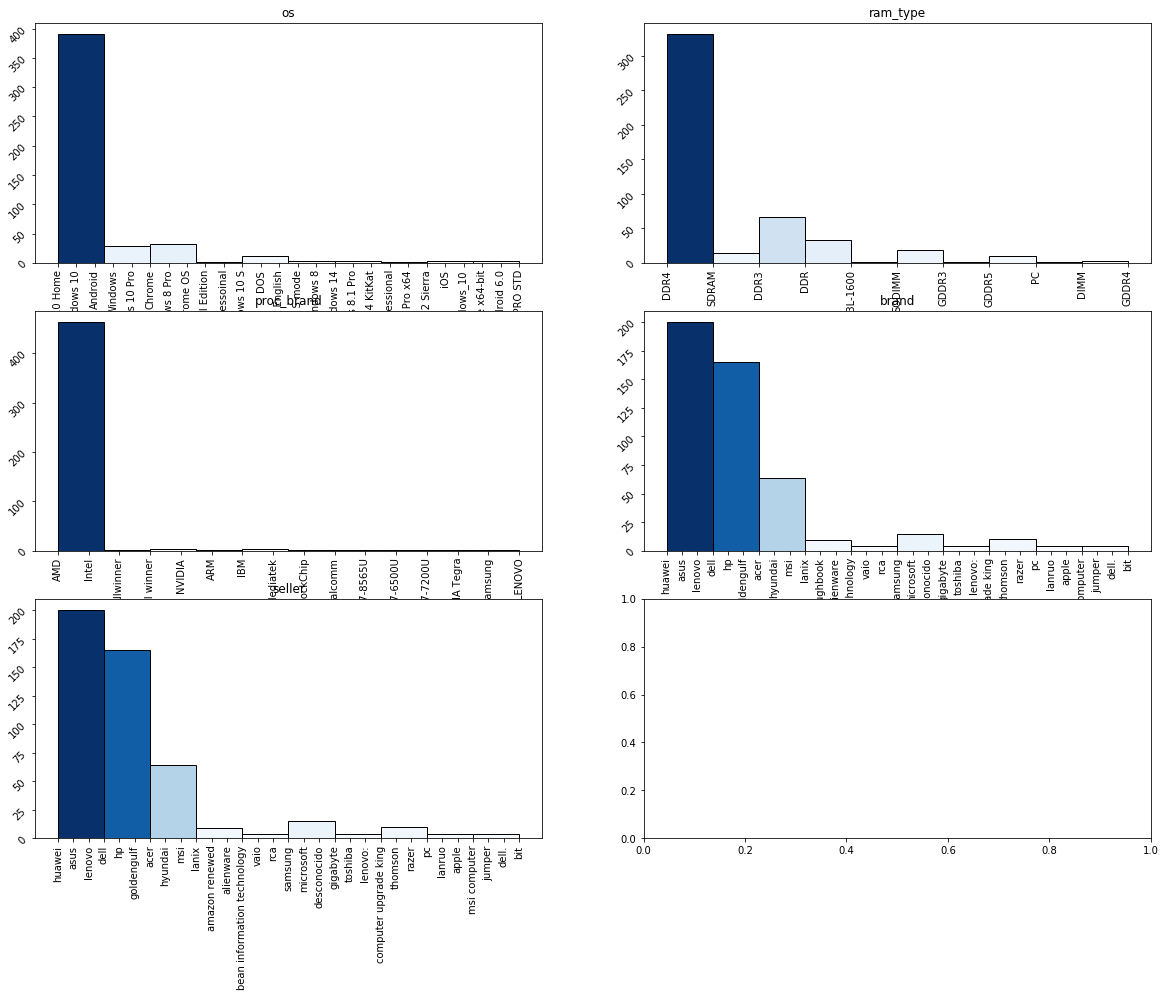

In [40]:
dynamic_plot(df, 'category')

In [41]:
def drop_contains(dataframe, columns_names):
    # columns_names = dataframe.select_dtypes(include='category').columns
    for column in columns_names:

        half_list_uniques = np.ceil( len( dataframe[column].unique() ) / 2 ).astype('int')
        list_uniques = dataframe[column].unique()[ 0:half_list_uniques ]

        for unique in list_uniques:
            dataframe[column] [ dataframe[column].str.contains(unique, case=False) ] = unique

In [42]:
df.select_dtypes(include='category').columns

Index(['seller', 'brand', 'proc_brand', 'ram_type', 'os'], dtype='object')

In [43]:
drop_contains(df, ['seller', 'brand', 'proc_brand', 'os'])

## Showing filtered data and exporting processed data


### Plotting numeric variables

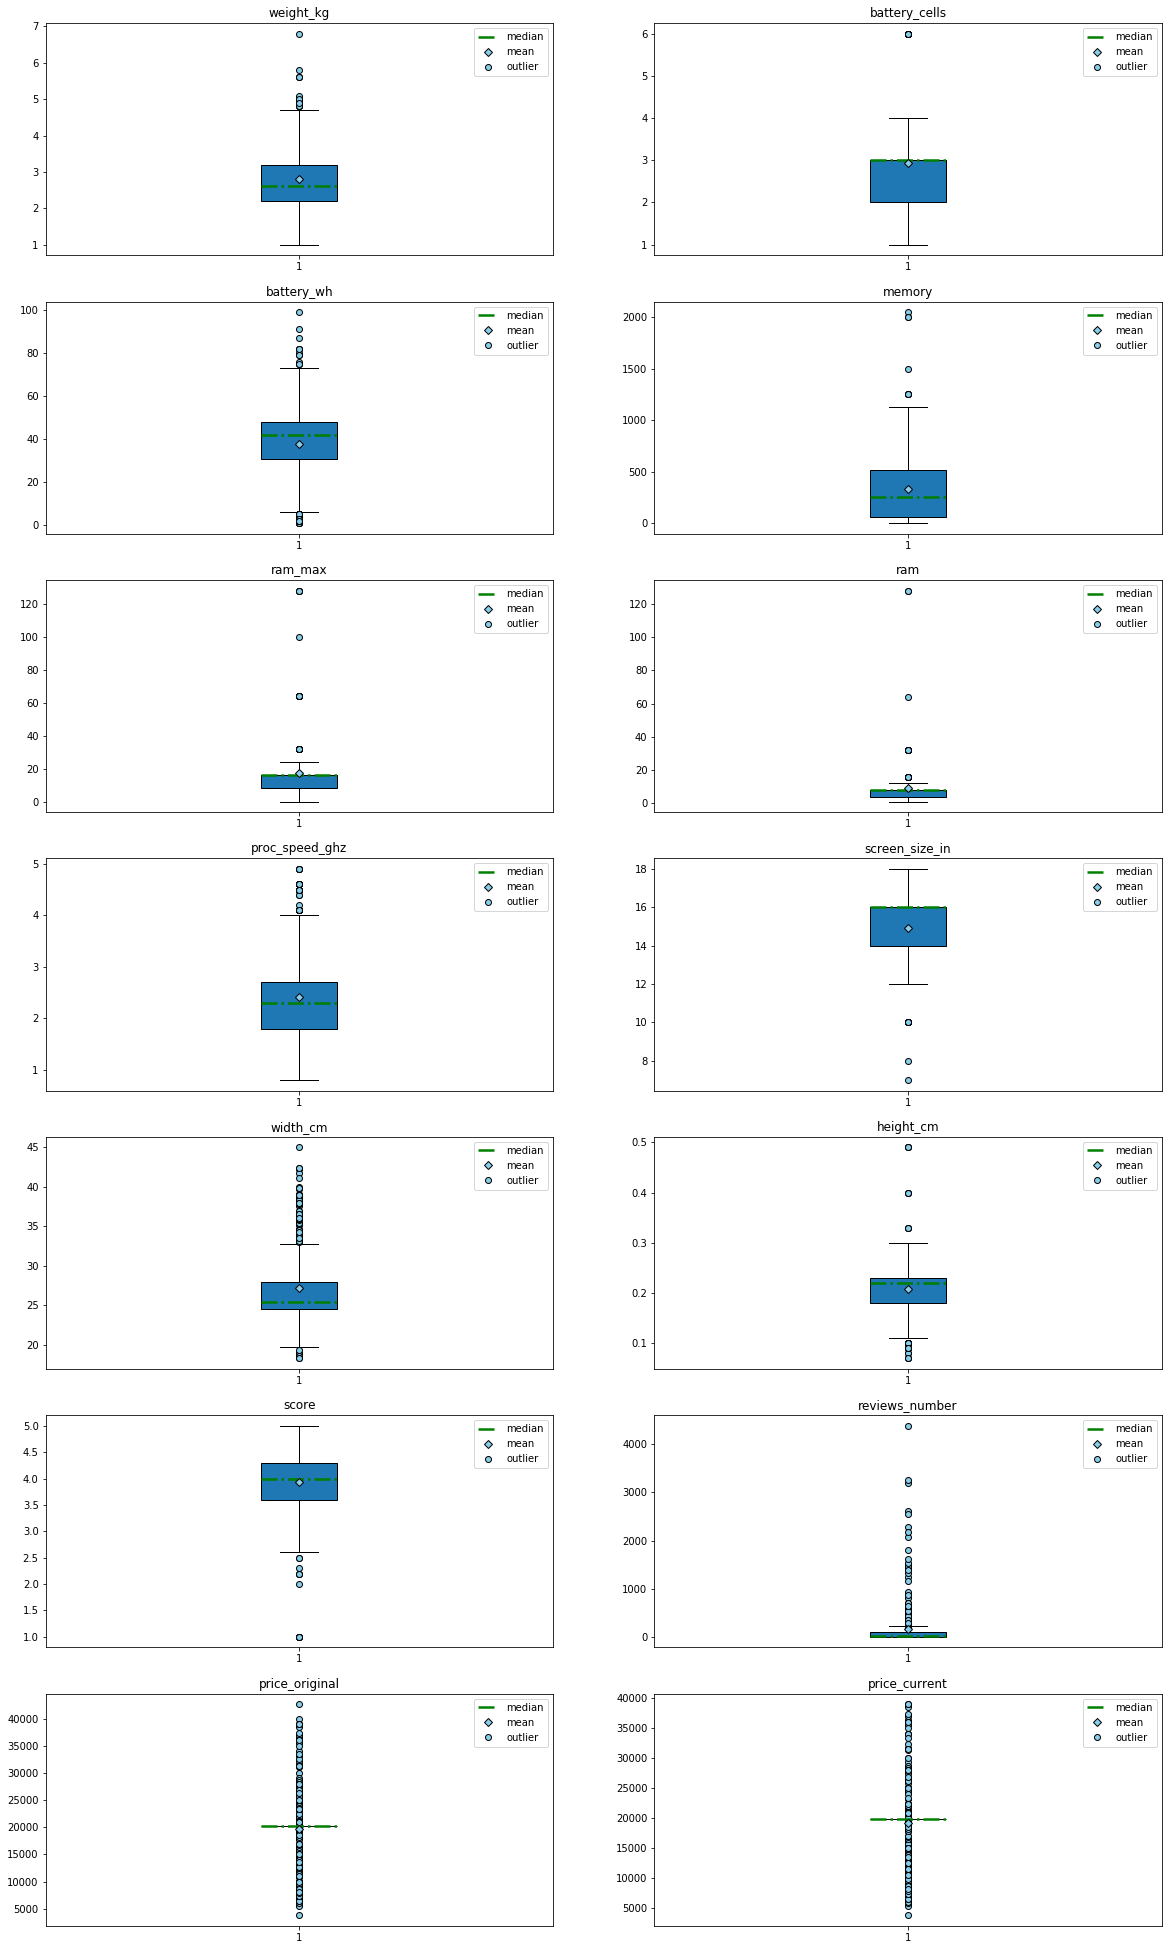

In [44]:
dynamic_plot(df)

### Plotting categorical variables

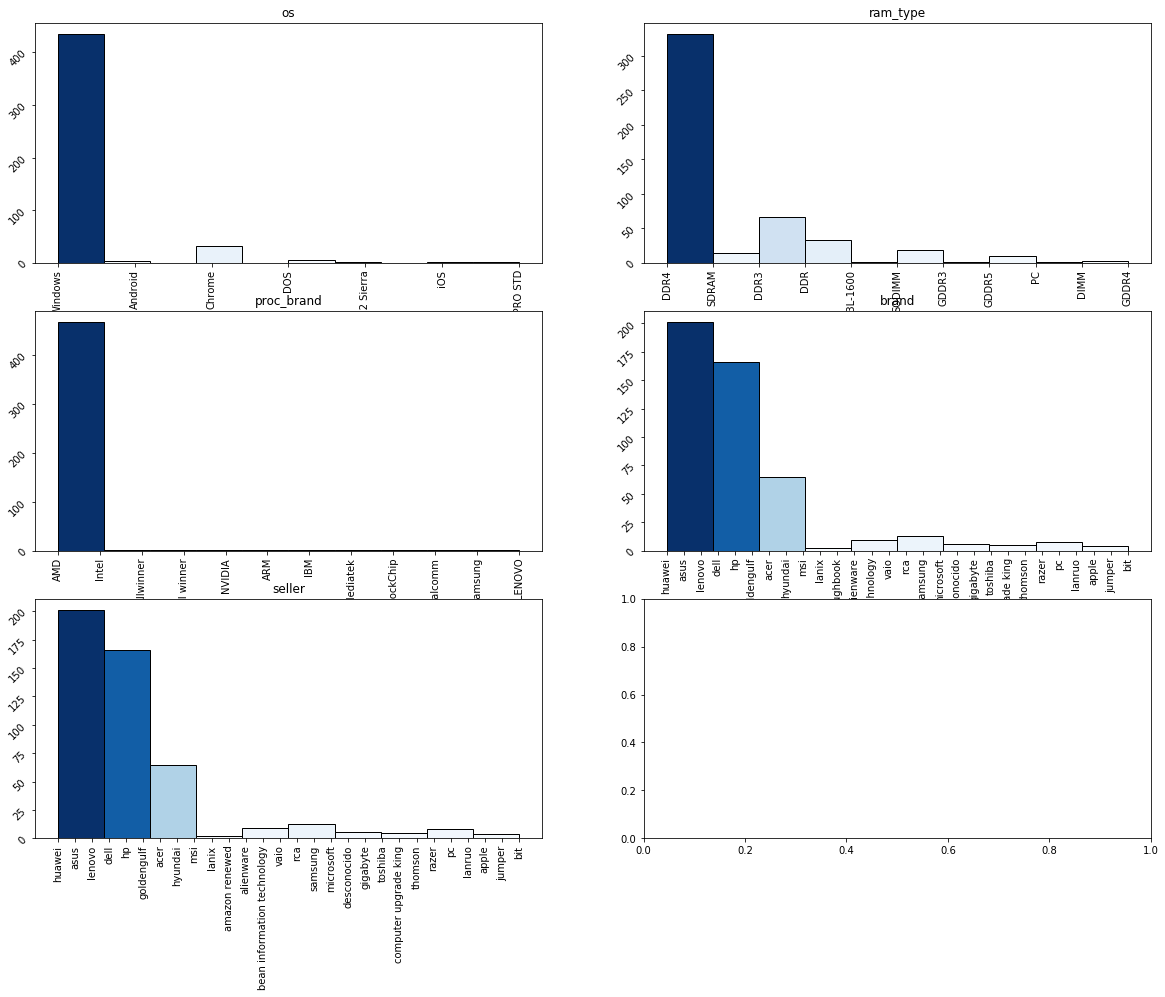

In [45]:
dynamic_plot(df, 'category')

In [46]:
df.head(2)

,name,price_current,price_original,reviews_number,seller,score,brand,height_cm,width_cm,screen_size_in,...,proc_speed_ghz,ram,ram_type,ram_max,memory,os,battery_wh,battery_cells,weight_kg,since
0,"Huawei MateBook D 15"" - AMD Ryzen, Windows 10-...",14999.0,14999.0,156,huawei,4.7,huawei,0.17,35.80,15,...,2.2,8,DDR4,8,256,Windows,42,2,2.3,2020-02-20
1,"Asus Laptop VivoBook 15.6"", Core i7, 8GB RAM,...",17999.0,19999.0,28,asus,4.0,asus,0.22,25.45,16,...,1.8,8,DDR4,12,8,Windows,42,1,2.5,2020-03-10


In [47]:
df.to_csv('../Data/amazon_filtered_' + datetime.datetime.today().strftime('%m%d') + '.csv')

In [48]:
df_time = df.set_index(df.since).copy()
df_time.head(2)

,name,price_current,price_original,reviews_number,seller,score,brand,height_cm,width_cm,screen_size_in,...,proc_speed_ghz,ram,ram_type,ram_max,memory,os,battery_wh,battery_cells,weight_kg,since
since,,,,,,,,,,,,,,,,,,,,,
2020-02-20,"Huawei MateBook D 15"" - AMD Ryzen, Windows 10-...",14999.0,14999.0,156,huawei,4.7,huawei,0.17,35.80,15,...,2.2,8,DDR4,8,256,Windows,42,2,2.3,2020-02-20
2020-03-10,"Asus Laptop VivoBook 15.6"", Core i7, 8GB RAM,...",17999.0,19999.0,28,asus,4.0,asus,0.22,25.45,16,...,1.8,8,DDR4,12,8,Windows,42,1,2.5,2020-03-10


In [49]:
df_time.resample('Y').mean()

,price_current,price_original,reviews_number,score,height_cm,width_cm,screen_size_in,proc_speed_ghz,ram,ram_max,memory,battery_wh,battery_cells,weight_kg
since,,,,,,,,,,,,,,
2014-12-31,12862.660000,12972.660000,158.333333,3.300000,0.206667,30.116667,13.333333,2.233333,3.333333,14.666667,214.666667,41.333333,5.000000,2.566667
2015-12-31,16214.500000,16946.625000,547.875000,3.562500,0.235000,30.768750,13.875000,1.995000,6.375000,7.625000,195.250000,39.375000,3.375000,2.900000
2016-12-31,16288.363750,16547.280417,664.791667,3.645833,0.231667,28.333333,13.750000,2.110000,7.458333,12.500000,306.416667,30.375000,3.083333,2.525000
2017-12-31,19497.676479,20270.233380,181.000000,3.654930,0.211690,27.070423,14.690141,2.156620,9.183099,16.873239,301.042254,37.492958,2.788732,2.726761
2018-12-31,19701.558824,20075.020392,191.500000,3.862745,0.208431,28.304902,14.843137,2.378431,8.225490,17.558824,481.411765,38.068627,3.107843,2.842157
2019-12-31,19307.715143,19723.296857,80.587755,4.085714,0.204449,26.502449,15.224490,2.532449,10.216327,18.787755,312.697959,37.955102,2.934694,2.853469
2020-12-31,20686.466154,21221.620000,148.615385,4.119231,0.210385,26.742308,15.000000,2.653846,8.846154,14.461538,179.192308,40.807692,2.000000,2.680769


In [50]:
df_time.resample('Y').median()

,price_current,price_original,reviews_number,score,height_cm,width_cm,screen_size_in,proc_speed_ghz,ram,ram_max,memory,battery_wh,battery_cells,weight_kg
since,,,,,,,,,,,,,,
2014-12-31,12350.00,12350.00,54.0,3.30,0.22,30.500,14.0,2.30,4,16,128,40.0,6,2.40
2015-12-31,19894.50,20224.50,136.0,3.55,0.23,29.700,15.0,2.05,4,8,144,38.5,4,3.00
2016-12-31,19894.50,20224.50,65.0,3.60,0.22,25.625,13.5,2.30,4,8,128,33.0,3,2.25
2017-12-31,19894.50,20224.50,68.0,3.70,0.22,25.450,16.0,2.30,8,16,64,42.0,2,2.60
2018-12-31,19894.50,20224.50,37.5,3.95,0.22,25.700,16.0,2.20,8,16,256,41.0,3,2.60
2019-12-31,19894.50,20224.50,20.0,4.10,0.22,25.450,16.0,2.30,8,16,256,42.0,3,2.60
2020-12-31,20446.75,20611.75,28.0,4.00,0.22,25.450,16.0,2.30,8,14,256,42.0,1,2.55
